## WallStreetQuant Course Project

#### Author: Kevin Tan YueJun
##### Strategy 2: Moving Average Cross-Over Momentum Strategy

**Statistical Arbitrage in Cryptocurrencies** (Background)

*Statistical arbitrage* is a class of strategies that tries to discover price-volume patterns that predict returns. It is one of the most popular and successful quantitative hedge-fund strategies, and given that the cryptocurrency markets are still relatively new, it should provide fertile grounds for finding market inefficiencies using statistical arbitrage techniques. The two main patterns exploited in statistical arbitrage are momentum and reversal. 

**Key Intuitions and Assumptions Made**:
- Strategy employed is: Moving Average Cross-Over Momentum Strategy
- For portfolio performance evaluation, the following metrics will be used in strategy assessment:
  - *returns, volatility, sharpes, max drawdowns, alpha / beta, holding period, information ratio*
- For our assets that constitute our portfolio, we will be trading with **BTCUSDT**, **ETHUSDT**, **XRPUSDT**, **LTCUSDT**, **LINKUSDT**, **ADAUSDT**, **BNBUSDT**, **DOGEUSDT**
- The benchmark for strategy comparison will be a **buy-and-hold** strategy for Bitcoin (BTCUSDT) over the period of analysis
- Period of Analysis: 5 year time horizon from 1-Jan-2020 to 31-Dec-2025

  Signal Generation Method: MA cross-over
  - If short term MA crosses above the long term MA, LONG the trading pair
  - If short term MA crosses below the long term MA, exit the LONG position
  - In our second implementation, we will be experimenting with SHORT position
  
  Method for trading-pairs allocation (% across long)
  - We will allocate equal weights to our LONG trading pairs
  - Strategy improvements: Equal-Volatility Portfolio allocation, and a SHORT component in our strategy

---

**Order/Section of the Notebook**
1. Import Libraries and Data
2. Parameter Initialisation
3. Data Retrieval and Formatting
4. Crypto Strategy
    - Grid Search
    - Signal Generation and Backtesting
    - Running the strategy on our basket of trading pairs 
5. Performance Evaluation
6. Strategy Improvements
    - Modifying the Moving Averages from simple to exponential
    - Include a SHORT component when the short term MA crosses below the long term MA
    - Equal Volatility Weights
7. Modelling Transaction Cost and other Factors
8. Potential Model Shortfalls and Limitations
9. Conclusion
  

#### **1. Import Libraries and Data**

The following section will be a list of all the libraries that we will import for our testing

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns

from matplotlib import pyplot as plt
from binance.client import Client
from datetime import datetime

#### **2. Parameter Initialisation**

We will initialise all our global parameters variables here

In [2]:
start_date, end_date = "1 Jan, 2020", "31 Dec, 2025"
trading_pairs = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "ADAUSDT", "LINKUSDT", "LTCUSDT", "DOGEUSDT"]

# Train-test split by dates
# Train 2020 -2024, Test 2025
train, test = "2020-01-01", "2024-12-31"

market_order_fee = 0.0020  # 0.2% per trade
limit_order_fee = 0.0007  # 0.07% per trade

#### **3. Data Retrieval and Formatting**

Download the open, high, low and close data for our basket of cryptocurrencies. For the trading pairs that we are using, they will be retrieved from the **Binance** website using a public endpoint

In [3]:
# Retrieving a list of all available coins from Binance and selecting the trading pairs we have initialised above
client = Client()
futures_exchange_info = client.futures_exchange_info()  # request info on all futures symbols
trading_pairs = [info['symbol'] for info in futures_exchange_info['symbols'] if info['symbol'] in trading_pairs]
print("Trading pairs: ", trading_pairs)

Trading pairs:  ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'LINKUSDT', 'ADAUSDT', 'BNBUSDT', 'DOGEUSDT']


**Data Download**

We will define a method to download the historical data for a basket of cryptocurrencies

In [4]:
# Method to format the downloaded data from Binance, which returns the data in a list of lists
def format_binance(data):
  columns = ['open_time','open','high','low','close','volume','close_time','quote_volume','num_trades','taker_base_volume','taker_quote_volume','ignore']
  data = pd.DataFrame(data, columns = columns)
  
  # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
  data['open_time'] = data['open_time'].map(lambda x: datetime.fromtimestamp(x/1000))
  data['close_time'] = data['close_time'].map(lambda x: datetime.fromtimestamp(x/1000))
  
  # For our analysis, we only need the date and close columns. As for the date column, we will use the open_time column
  data = data[['open_time','close']]
  data['open_time'] = pd.to_datetime(data['open_time']).dt.date
  data.rename(columns={'open_time':'date'}, inplace=True)
  return data

""" Use client.KLINE_INTERVAL and tab to check the available time intervals for download
E.g
- client.KLINE_INTERVAL_1MINUTE
- client.KLINE_INTERVAL_1HOUR
- client.KLINE_INTERVAL_2HOUR
- client.KLINE_INTERVAL_1DAY
- client.KLINE_INTERVAL_1WEEK
...etc
"""
def download_data(trading_pairs):
  crypto_data = {}
  for symbol in trading_pairs:
    # We will first check to see if the trading pair data (pkl file) exists on our local machine before downloading it from Binance
    directory = f"Crypto-Data/{symbol}_data.pkl"
    if os.path.exists(directory):
      crypto_data[symbol] = pd.read_pickle(directory)
      continue
    try:
      klines = client.get_historical_klines(symbol, client.KLINE_INTERVAL_1DAY, start_date, end_date)
      crypto_data[symbol] = format_binance(klines)
      # Save it as a pkl file on our local machine for future use
      crypto_data[symbol].to_pickle(directory)
    except Exception as e:
      print(f"Error retrieving data for {symbol}: {e}")      
  return crypto_data

def consolidate_trading_pairs(crypto_data):
  trading_pairs = pd.DataFrame()
  for symbol, data in crypto_data.items():
    data.set_index('date', inplace=True)
    data.rename(columns={'close': symbol}, inplace=True)
    if trading_pairs.empty:
      trading_pairs = data
    else:
      trading_pairs = trading_pairs.join(data, how='outer')
  
  # Given that some trading pairs may not have data for all dates, we will drop them for our analysis
  print(f"Original number of trading pairs: {trading_pairs.shape[1]}")
  trading_pairs.dropna(axis=1, inplace=True)
  print(f"Number of trading pairs after dropping those with missing data: {trading_pairs.shape[1]}")
  
  # Convert the data type to float for numerical analysis
  trading_pairs = trading_pairs.astype(float)
  return trading_pairs

In [5]:
crypto_data = download_data(trading_pairs)
trading_pairs_df = consolidate_trading_pairs(crypto_data)

Original number of trading pairs: 8
Number of trading pairs after dropping those with missing data: 8


Data Checks

In [6]:
print(f"Original number of records: {trading_pairs_df.shape[0]}")
trading_pairs_df = trading_pairs_df[~trading_pairs_df.index.duplicated(keep='first')]
print(f"Number of records after removing duplicates: {trading_pairs_df.shape[0]}")

Original number of records: 2192
Number of records after removing duplicates: 2192


From our output above, we have dropped a total of 409 trading pairs that do not have data from as far back as 2020. Only 51 trading pairs remain, which would suffice for our trading strategy.

#### Quick Visualisation of our crypto trading pairs

Let us generate a plot of the crypto trading pairs from our given dataset. Given that the some cryptocurrency prices are significantly larger than the rest, we will set a threshold to exclude trading paris with a price above a certain amount.

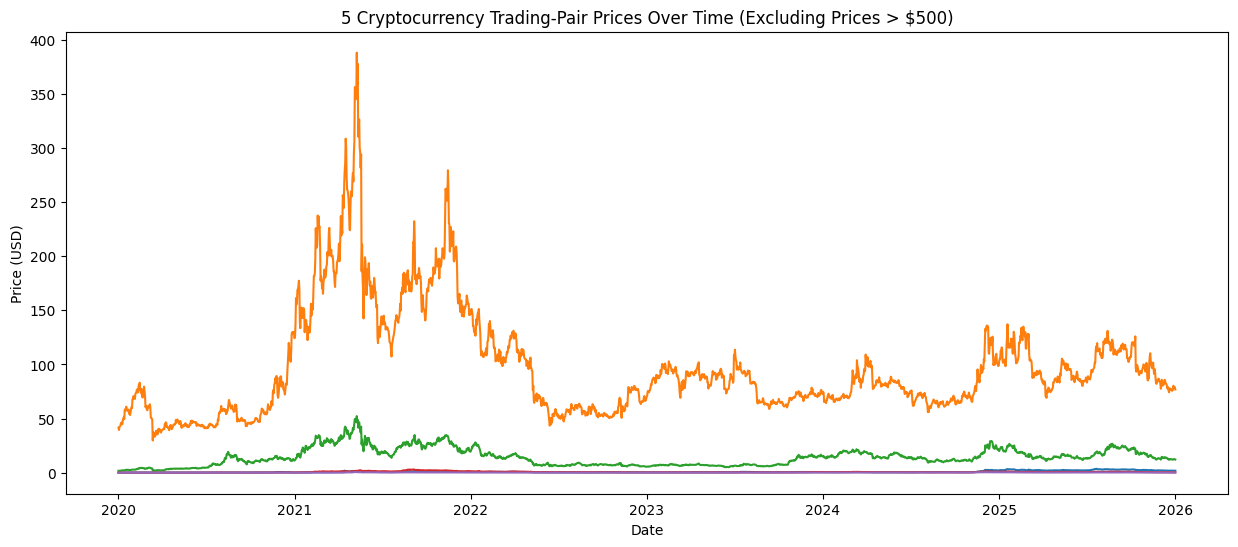

In [7]:
threshold_price = 500
exclude_symbols = [symbol for symbol in trading_pairs_df.columns if trading_pairs_df[symbol].max() > threshold_price]

plot_data = trading_pairs_df.drop(columns=exclude_symbols)

plt.figure(figsize=(15, 6))
for column in plot_data.columns:
  plt.plot(plot_data.index, plot_data[column], label=column)

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'{len(plot_data.columns)} Cryptocurrency Trading-Pair Prices Over Time (Excluding Prices > ${threshold_price})')
plt.show()

**Split the dataset for training and testing**

- Train: 2020 - 2024
- Test: 2025

In [8]:
# Select our training set which comprise of data from 2020 to 2024
trading_pairs_df.index = pd.to_datetime(trading_pairs_df.index)
train_data = trading_pairs_df[(trading_pairs_df.index > train) & (trading_pairs_df.index <= test)]
test_data = trading_pairs_df[trading_pairs_df.index > test]

#### **4. Crypto Strategy**

**Momentum Strategy to deploy**: *MA Cross-Over Momentum Strategy*

The intuition here is that assets that performed well over a given time period will display momentum and continue its outperformance in the short run, while assets that delivered poorer returns will continue to underperform in the short run.

Description of the strategy:
- We will be using 2 simple moving averages to determine our signal for each trading pair
- When the short term MA crosses above the long term MA, we will long the trading pair
- When the short term MA crosses below the long term MA, we will exit the long position





##### a. Grid-Search

To identify the ideal short-term and long-term simple moving averages. We can initialise the strategy over a range of values:
- Short Term Moving Average Window (1 - 50 days)
- Long Term Moving Average Window (ST MA - 50 days)

For each set of ST and LT moving averages, we will be calculating the Sharpe Ratio

##### b. Signal Generation and Backtesting

Let us define the function for calculating the simple moving averages given a lookback period parameter, as well as a function to compute the signals for going LONG

In [9]:
def simple_moving_average(dataframe, window):
  return dataframe.rolling(window=window).mean()

def compute_ma_crossover_strategy(dataframe, short_window, long_window):
  df = dataframe.copy()
  # Compute the short and long moving averages for each trading pair in our dataset
  for symbol in df.columns:
    df[f'{symbol}_SMA_{short_window}'] = simple_moving_average(df[symbol], short_window)
    df[f'{symbol}_SMA_{long_window}'] = simple_moving_average(df[symbol], long_window)
    
  # Compute the LONG signal
  for symbol in df.columns:
    if '_SMA_' in symbol:
      continue
    short_sma = df[f'{symbol}_SMA_{short_window}']
    long_sma = df[f'{symbol}_SMA_{long_window}']
    df[f'{symbol}_LONG_signal'] = np.where(short_sma > long_sma, 1.0, 0.0)
  
  # Equal weight allocation across all trading pairs that have a LONG signal
  signal_df = df.filter(like='_LONG_signal')
  num_long_signals = signal_df.sum(axis=1)
  weights_long = signal_df.div(num_long_signals, axis=0).fillna(0.0)
  
  # remove the long_signal wording on the weights dataframe to make them the same as the trading pairs
  weights_long.columns = [col.replace('_LONG_signal', '') for col in weights_long.columns]

  # Compute the daily returns for each trading pair
  returns_df = dataframe
  daily_returns = returns_df.pct_change().fillna(0)
  
  # Avoid look-ahead bias by shifting the weights by 1 day
  weights_long = weights_long.shift(1).fillna(0.0)

  # Compute the portfolio returns on each day
  portfolio_returns = (weights_long * daily_returns).sum(axis=1)
  return pd.DataFrame(portfolio_returns, columns=["Strategy Return"])

def visualise_signals_on_plot(dataframe, symbol, short_window, long_window):
  df = dataframe.copy()
  df[f'SMA_{short_window}'] = simple_moving_average(df[symbol], short_window)
  df[f'SMA_{long_window}'] = simple_moving_average(df[symbol], long_window)

  # Generate signals
  df['signal'] = 0
  df.loc[df[f'SMA_{short_window}'] > df[f'SMA_{long_window}'], 'signal'] = 1
  df.loc[df[f'SMA_{short_window}'] < df[f'SMA_{long_window}'], 'signal'] = -1

  # Detect crossovers
  buy_signals = df[(df['signal'] == 1) & (df['signal'].shift(1) <= 0)]
  sell_signals = df[(df['signal'] == -1) & (df['signal'].shift(1) >= 0)]

  # Create subplots
  fig, (ax_price, ax_signal) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

  # ===== Price + SMA plot =====
  ax_price.plot(df.index, df[symbol], label=f'{symbol} Price')
  ax_price.plot(df.index, df[f'SMA_{short_window}'], label=f'SMA {short_window}')
  ax_price.plot(df.index, df[f'SMA_{long_window}'], label=f'SMA {long_window}')

  ax_price.scatter(buy_signals.index, buy_signals[symbol], marker='^', color='g', s=80, label='Buy')
  ax_price.scatter(sell_signals.index, sell_signals[symbol], marker='v', color='r', s=80, label='Sell')

  ax_price.set_title(f'{symbol} MA Crossover (SMA {short_window} / SMA {long_window})')
  ax_price.set_ylabel('Price')
  ax_price.legend()
  ax_price.grid(True)

  # ===== Signal subplot =====
  ax_signal.step(df.index, df['signal'], where='post')
  ax_signal.axhline(0)
  ax_signal.set_ylabel('Signal')
  ax_signal.set_yticks([-1, 0, 1])
  ax_signal.set_yticklabels(['Short', 'Flat', 'Long'])
  ax_signal.grid(True)

  plt.xlabel('Date')
  plt.tight_layout()
  plt.show()
  
def backtest_strategy(dataframe, short_window, long_window):
  short_window_list = []
  long_window_list = []
  sharpe_ratio = []
  for sw in short_window:
    for lw in long_window:
      if sw >= lw:
        continue
      
      portfolio_returns = compute_ma_crossover_strategy(dataframe, sw, lw)
      portfolio_returns = portfolio_returns["Strategy Return"]
      # Compute the Sharpe Ratio (assuming risk-free rate is 0)
      sr = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
      sharpe_ratio.append(sr)
      short_window_list.append(sw)
      long_window_list.append(lw)
  
  results_df = pd.DataFrame({
    'Short_Window': short_window_list,
    'Long_Window': long_window_list,
    'Sharpe_Ratio': sharpe_ratio
  })
  return results_df

def performance_heatmap(dataframe):
  # Print the top 3 set of optimal parameters
  top3_values = dataframe['Sharpe_Ratio'].nlargest(3).unique()
  optimal_params_top3 = dataframe.loc[dataframe['Sharpe_Ratio'].isin(top3_values), ['Short_Window', 'Long_Window', 'Sharpe_Ratio']].sort_values(by='Sharpe_Ratio', ascending=False)
  print("Top 3 Optimal Parameters (Short Window, Long Window):")
  for index, row in optimal_params_top3.iterrows():
    print(f"Short Window: {row['Short_Window']}, Long Window: {row['Long_Window']}, Sharpe Ratio: {row['Sharpe_Ratio']:.4f}")
  
  # Sort the short and long window in ascending order
  dataframe = dataframe.sort_values(by=['Short_Window', 'Long_Window'])
  heatmap_data = dataframe.pivot(
    index="Short_Window",
    columns="Long_Window",
    values="Sharpe_Ratio"
  )
  plt.figure(figsize=(8, 6))
  sns.heatmap(heatmap_data, fmt=".2f", cmap="YlGnBu")
  plt.title("MA Crossover Strategy Performance Heatmap (Sharpe Ratio)")
  plt.show()

Backtesting on our training data

In [10]:
short_window_range = np.arange(1, 50, 1)  # Adjust the steps as needed
long_window_range = np.arange(1, 50, 1)  # Adjust the steps as needed

training_results = backtest_strategy(train_data, short_window_range, long_window_range)

Top 3 Optimal Parameters (Short Window, Long Window):
Short Window: 24.0, Long Window: 25.0, Sharpe Ratio: 1.4729
Short Window: 5.0, Long Window: 12.0, Sharpe Ratio: 1.4504
Short Window: 4.0, Long Window: 5.0, Sharpe Ratio: 1.4305


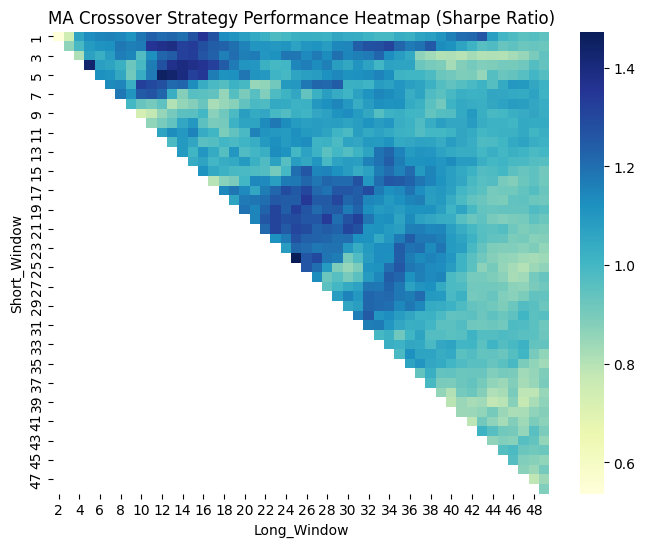

In [11]:
performance_heatmap(training_results)

Let us generate a sample plot and see how the signals would be like on one of the tradable assets across time.

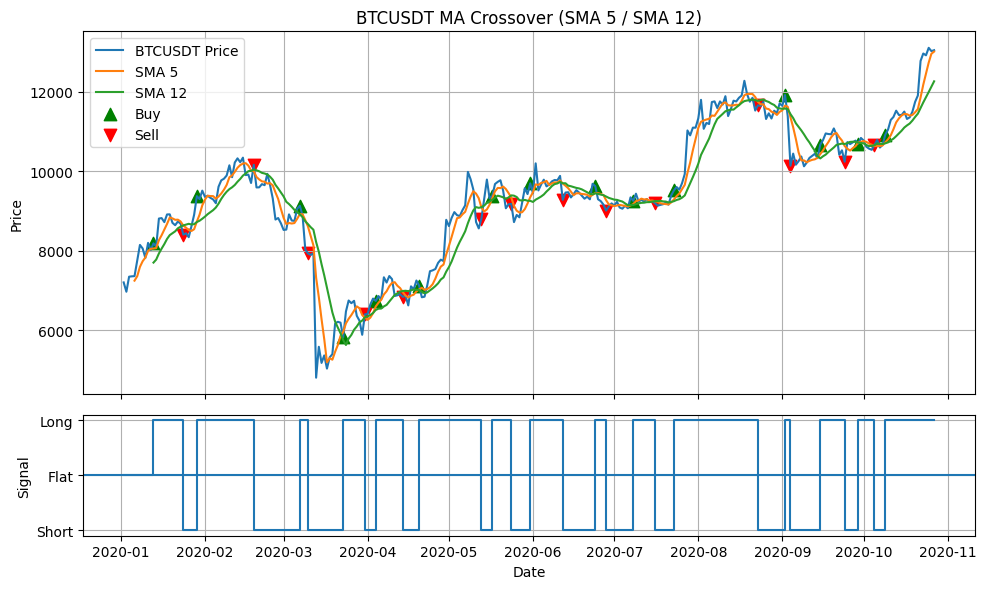

In [12]:
asset = 'BTCUSDT'

dummy_data = train_data[:300]
visualise_signals_on_plot(dummy_data, asset, short_window=5, long_window=12)

From the chart above, we can see that our BUY and SELL signals are generated everytime the MAs crossover occur. In the lower half of the visual, we see our signal chart showing the long / short / flat position at every point in time. Given that we are fully invested in an asset across time, it is expected that we see a sharp change from +1 to -1 and vice versa, which means we will never be uninvested in the asset across time.

##### c. Running the strategy on our basket of trading pairs

Our backtesting results yielded an optimal Sharpe with **Short-Term Moving Average (24 days)** and **Long-Term Moving Average (25 days)**. However, given that the difference between the STMA and LTMA is only 1 day, we will look to our next best alternative, which is **Short-Term Moving Average (5 days)** and **Long-Term Moving Average (12 days)**, yielding an annualised sharpe of 1.45

**Running the strategy on our basket of trading pairs**

In [13]:
short_window_optimal = 5
long_window_optimal = 12
test_strategy_returns = compute_ma_crossover_strategy(test_data, short_window=short_window_optimal, long_window=long_window_optimal)

# Benchmark: BTCUSDT huy and hold returns
test_benchmark_returns = test_data[['BTCUSDT']].pct_change()

#### **5. Performance Evaluation**

Let us define the functions to compute our strategy and benchmark performance metrics. As for the metrics that we will be using, they are:
1. Annualised Return
2. Annualised Volatility
3. Sharpe Ratio
4. Hit Rate
5. Max Drawdown
6. Drawdown Duration
7. Alpha and Beta

As for the derivation of Alpha and Beta, we will be running a OLS linear regression of our portfolio returns on our benchmark. 

**Model Summary:**

$$
Portfolio_t \sim \alpha + \beta \times BTCUSDT_t + e_t
$$


- **Alpha (α)** measures **excess return** not explained by the market:
  - $\alpha > 0$: FB has **outperformed** what the market model predicts.
  - $\alpha < 0$: FB has **underperformed** relative to its market exposure.

- **Beta (β)** measures **systematic risk**:
  - $\beta > 1$: FB moves **more** than the market (high volatility, higher risk).
  - $\beta < 1$: FB moves **less** than the market (defensive behavior).
  - $\beta = 1$: FB moves roughly **in sync** with the market.

With the OLS regression model constructed, we can retrieve details on the following key variables:
- $\beta$: Our beta term which explains how correlated our asset is to the benchmark
- Portfolio<sub>t</sub>: Our predictor variable
- $\alpha$ + e<sub>t</sub>: The 'tradeable strategy' or the Alpha term and the residual


In [14]:
## Compute the performance metrics of our strategy
def strategy_performance_metrics(dataframe):
  df = dataframe.copy()
  # Annualised Return
  annualised_return = (1 + df['Strategy Return'].mean()) ** 252 - 1
  # Annualised Volatility
  annualised_volatility = df['Strategy Return'].std() * np.sqrt(252)
  # Sharpe Ratio
  sharpe_ratio = (df['Strategy Return'].mean() / df['Strategy Return'].std()) * np.sqrt(252)
  # Hit Rate
  hit_rate = (df['Strategy Return'] > 0).mean()
  
  # Drawdown for the strategy
  df['Strategy'] = (1 + df['Strategy Return']).cumprod()
  drawdown_values = draw_down(df[['Strategy']])
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
  
  drawdown_duration = draw_down_duration(df[['Strategy']])
  max_drawdown_duration = drawdown_duration.max().values[0]

  return {
    'Annualised Return': annualised_return,
    'Annualised Volatility': annualised_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Hit Rate': hit_rate,
    'Max Drawdown (%)': max_drawdown,
    'Max Drawdown Duration (Periods)': max_drawdown_duration
  }
  
def benchmark_performance_metrics(dataframe):
  df = dataframe.copy()
  df['Daily Return'] = df['BTCUSDT'].pct_change()
  # Annualised Return
  annualised_return = (1 + df['Daily Return'].mean()) ** 252 - 1
  # Annualised Volatility
  annualised_volatility = df['Daily Return'].std() * np.sqrt(252)
  # Sharpe Ratio
  sharpe_ratio = (df['Daily Return'].mean() / df['Daily Return'].std()) * np.sqrt(252)
  # Hit Rate
  hit_rate = (df['Daily Return'] > 0).mean()
  
  # Drawdown for the strategy
  df['Benchmark'] = (1 + df['Daily Return']).cumprod()
  drawdown_values = draw_down(df[['Benchmark']])
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
  
  drawdown_duration = draw_down_duration(df[['Benchmark']])
  max_drawdown_duration = drawdown_duration.max().values[0]

  return {
    'Annualised Return': annualised_return,
    'Annualised Volatility': annualised_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Hit Rate': hit_rate,
    'Max Drawdown (%)': max_drawdown,
    'Max Drawdown Duration (Periods)': max_drawdown_duration
  }
  
def compare_strat_and_benchmark(strat_metrics, benchmark_metrics):
  comparison = pd.DataFrame({
    'Strategy': strat_metrics,
    'Benchmark': benchmark_metrics
  })
  return comparison

def draw_down(px):
  return (px / px.expanding(min_periods=1).max() - 1)

def draw_down_duration(dataframe):
  px = dataframe.copy()
  peak = px.expanding(min_periods=1).max()
  res = pd.DataFrame(0, index=px.index, columns=px.columns)

  for col in px.columns:
    prev_duration = 0  # keeps track of last duration safely
    for dt in px.index:
      current_px = px.at[dt, col]
      current_peak = peak.at[dt, col]
      """ 
      if statement:
      - If the current price is equal to the running peak, it means we have hit a new all-time high, so the drawdown ends and duration resets to 0.
      
      else statement:
      - If the current price is below the peak, that means we are still in a drawdown. The code looks at the previous duration value (the second last row, .iloc[-2]),
        and then adds +1, meaning another period has passed since the last peak. So duration keeps counting how many consecutive periods we have been under the last peak.
      """
      if current_px >= current_peak:
        res.at[dt, col] = 0
        prev_duration = 0
      else:
        prev_duration += 1
        res.at[dt, col] = prev_duration

  return res

# Define the function to generate a dataframe containing price of each local maxima
def drawdown_with_line(dataframe):
  px = dataframe.copy()
  dataframe = pd.DataFrame(index=px.index,columns=px.columns)  
  peak = px.expanding(min_periods=1).max()
  
  for col in px.columns:
    for dt in px.index:
      """ This is a slight modification of the if statement used in the duration function.
      if the current price is equal to or greater than the running peak, we set the value in our new dataframe
      to the current price (indicating a new peak). Otherwise, we set it to the previous peak value.
      """
      if px.loc[dt,col] >= peak.loc[dt,col]:
        dataframe.loc[dt,col] = px.loc[dt,col]
      else:
        dataframe.loc[dt,col] = peak.loc[dt,col]
  return dataframe

def draw_down_plot(dataframe):
  dd = draw_down(dataframe)
  dd.plot(title='Drawdown of Asset Over Time')
  plt.title("Drawdowns")
  plt.xlabel("Date")
  plt.ylabel("Drawdown") 
  plt.gcf().set_size_inches(15, 6)
  plt.show()

def draw_down_duration_plot(dataframe):
  ddd = draw_down_duration(dataframe)
  ddd.plot(title=f'Duration of Drawdown of Strategy and Benchmark Over Time')
  plt.title("Drawdown Duration")
  plt.xlabel("Date")
  plt.ylabel("Duration (Periods)") 
  plt.gcf().set_size_inches(15, 6)
  plt.show()

def draw_down_line_plot(dataframe, column_name):
  # Plot the horizontal line to illustrate our drawdown in the chart for our portfolio and benchmark
  hdd = drawdown_with_line(dataframe)
  dd = draw_down(dataframe)
  horiz_line = hdd[column_name]
  print(f"Maximum drawdown for {column_name}: {round(dd[column_name].min() * -100, 2)}%")
  plt.figure(figsize=(15,6))
  plt.plot(dataframe[column_name], label=f'{column_name} Price')
  plt.plot(horiz_line, label='Drawdown Line', linestyle='--')
  plt.title(f"{column_name} Price with Drawdown Line")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.show()

def plot_strategy_performance_cumprod(strategy_rets, asset_returns):
  # Plot the cumulative returns of our strategy against the benchmark (BTCUSDT buy-and-hold)
  cumulative_strategy_rets = (1 + strategy_rets).cumprod() - 1
  cumulative_btc_rets = (1 + asset_returns['BTCUSDT'].pct_change()).cumprod() - 1
  plt.figure(figsize=(15, 6))
  plt.plot(cumulative_strategy_rets.index, cumulative_strategy_rets, label='Momentum Strategy', color='blue')
  plt.plot(cumulative_btc_rets.index, cumulative_btc_rets, label='BTCUSDT Buy-and-Hold', color='orange')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.title('Cumulative Returns: Momentum Strategy vs BTCUSDT Buy-and-Hold')
  plt.legend()
  plt.show()
  
def plot_strategy_performance_cumsum(strategy_rets, asset_returns):
  # Plot the cumulative returns of our strategy against the benchmark (BTCUSDT buy-and-hold)
  # Convert to log returns before using cumsum
  cumulative_strategy_rets = strategy_rets.cumsum()
  cumulative_btc_rets = asset_returns['BTCUSDT'].pct_change().cumsum()
  plt.figure(figsize=(15, 6))
  plt.plot(cumulative_strategy_rets.index, cumulative_strategy_rets, label='Momentum Strategy', color='blue')
  plt.plot(cumulative_btc_rets.index, cumulative_btc_rets, label='BTCUSDT Buy-and-Hold', color='orange')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.title('Cumulative Returns: Momentum Strategy vs BTCUSDT Buy-and-Hold')
  plt.legend()
  plt.show()
  
# Derivation of Alpha and Beta using Linear Regression
def derive_alpha_beta(strategy_returns, benchmark_returns):
  df_reg = pd.concat([strategy_returns, benchmark_returns], axis=1)
  df_reg = df_reg.dropna()

  # set X and Y. Have to add constant
  X = df_reg[['Daily Return']] # Our independent variable
  X = sm.add_constant(X)  # Adds a constant term to the predictor
  Y = df_reg['Strategy Return'] # Our dependent variable
  
  results = sm.OLS(Y, X).fit()
  print(results.summary()) # Check the summary of our regression results
  
  """
  const is alpha
  Benchmark Returns is beta
  """
  print(f"Alpha: {results.params['const']}")
  print(f"Beta: {results.params['Daily Return']}")
  
  # Generate the regression plot
  beta_contr = results.params['Daily Return']*X['Daily Return']
  prediction = results.params['Daily Return']*X['Daily Return'] + results.params['const']
  alpha_contr = results.params['const'] + results.resid
  
  # Ensure correlation to benchmark is low to confirm market-neutrality
  print("Correlation between strategy returns and benchmark returns:", alpha_contr.corr(X['Daily Return']))
  
  # Our 3 key metrics
  print("Alpha:", alpha_contr.mean()) # This is the average return of the strategy
  print("Information Ratio:", alpha_contr.mean()/alpha_contr.std()*np.sqrt(252)) # This is the information ratio of the strategy
  print("Alpha t-stat:", results.tvalues['const']) # This is the t-stat of alpha
  
# Function to merge all plot into a single frame for easier viewing  
def combined_plots(strategy_rets, asset_returns):
  # Drawdown (%) and Duration
  combined = pd.concat([(1 + strategy_rets).cumprod(), (1 + asset_returns[['BTCUSDT']]).cumprod()], axis=1)
  combined.rename(columns={'Strategy Return':'Strategy', 'BTCUSDT':'Benchmark'}, inplace=True)
  dd = draw_down(combined)
  ddd = draw_down_duration(combined)
  
  # Cumulative Returns (cumprod)
  cumprod_strategy_rets = (1 + strategy_rets).cumprod() - 1
  cumprod_btc_rets = (1 + asset_returns['BTCUSDT']).cumprod() - 1
  
  # Cumulative Returns (cumsum)
  cumsum_strategy_rets = strategy_rets.cumsum()
  cumsum_btc_rets = asset_returns['BTCUSDT'].cumsum()
  

  # Alpha Component
  benchmark = asset_returns.copy()
  benchmark.rename(columns={'BTCUSDT':'Daily Return'}, inplace=True)
  df_reg = pd.concat([strategy_rets, benchmark['Daily Return']], axis=1)

  df_reg = df_reg.dropna()

  # set X and Y. Have to add constant
  X = df_reg[['Daily Return']] # Our independent variable
  X = sm.add_constant(X)  # Adds a constant term to the predictor
  Y = df_reg['Strategy Return'] # Our dependent variable
  
  results = sm.OLS(Y, X).fit()
  alpha_contr = results.params['const'] + results.resid
  
  # Create a 2x3 subplot layout
  fig, ax = plt.subplots(2, 3, figsize=(20, 12))
  
  # Drawdown Plot
  dd.plot(ax=ax[0,0], title='Drawdown of Strategy and Benchmark Over Time')
  ax[0,0].set_xlabel("Date")
  ax[0,0].set_ylabel("Drawdown")
  
  # Drawdown Duration Plot
  ddd.plot(ax=ax[0,1], title='Duration of Drawdown of Strategy and Benchmark Over Time')
  ax[0,1].set_xlabel("Date")
  ax[0,1].set_ylabel("Duration (Periods)")
  
  # Cumulative Returns Plot (cumprod)
  ax[0,2].plot(cumprod_strategy_rets.index, cumprod_strategy_rets, label='Momentum Strategy')
  ax[0,2].plot(cumprod_btc_rets.index, cumprod_btc_rets, label='BTCUSDT Buy-and-Hold')
  ax[0,2].set_title('Cumulative Returns (Cumprod): Momentum Strategy vs BTCUSDT Buy-and-Hold')
  ax[0,2].set_xlabel('Date')
  ax[0,2].set_ylabel('Cumulative Return')
  ax[0,2].legend()
  
  # Cumulative Returns Plot (cumsum)
  ax[1,0].plot(cumsum_strategy_rets.index, cumsum_strategy_rets, label='Momentum Strategy')
  ax[1,0].plot(cumsum_btc_rets.index, cumsum_btc_rets, label='BTCUSDT Buy-and-Hold')
  ax[1,0].set_title('Cumulative Returns (Cumsum): Momentum Strategy vs BTCUSDT Buy-and-Hold')
  ax[1,0].set_xlabel('Date')
  ax[1,0].set_ylabel('Cumulative Return')
  ax[1,0].legend()
  
  # Alpha Component Plot
  alpha_contr.cumsum().plot(ax=ax[1,1], title="Cumulative Returns of Tradeable Strategy (Alpha) Component")
  ax[1,1].set_xlabel("Date")
  ax[1,1].set_ylabel("Cumulative Returns")
  
  plt.tight_layout()
  plt.show()

In [15]:
# Compare our strategy against the benchmark
test_strategy_returns_metrics = strategy_performance_metrics(test_strategy_returns)
benchmark_metrics = benchmark_performance_metrics(test_data)
performance_comparison = compare_strat_and_benchmark(test_strategy_returns_metrics, benchmark_metrics)
performance_comparison

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_3932/2008990353.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_3932/2008990353.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage


,Strategy,Benchmark
Annualised Return,-0.318434,0.014711
Annualised Volatility,0.508840,0.346389
Sharpe Ratio,-0.752831,0.042162
Hit Rate,0.346995,0.500000
Max Drawdown (%),64.467202,32.022515
Max Drawdown Duration (Periods),348.000000,116.000000


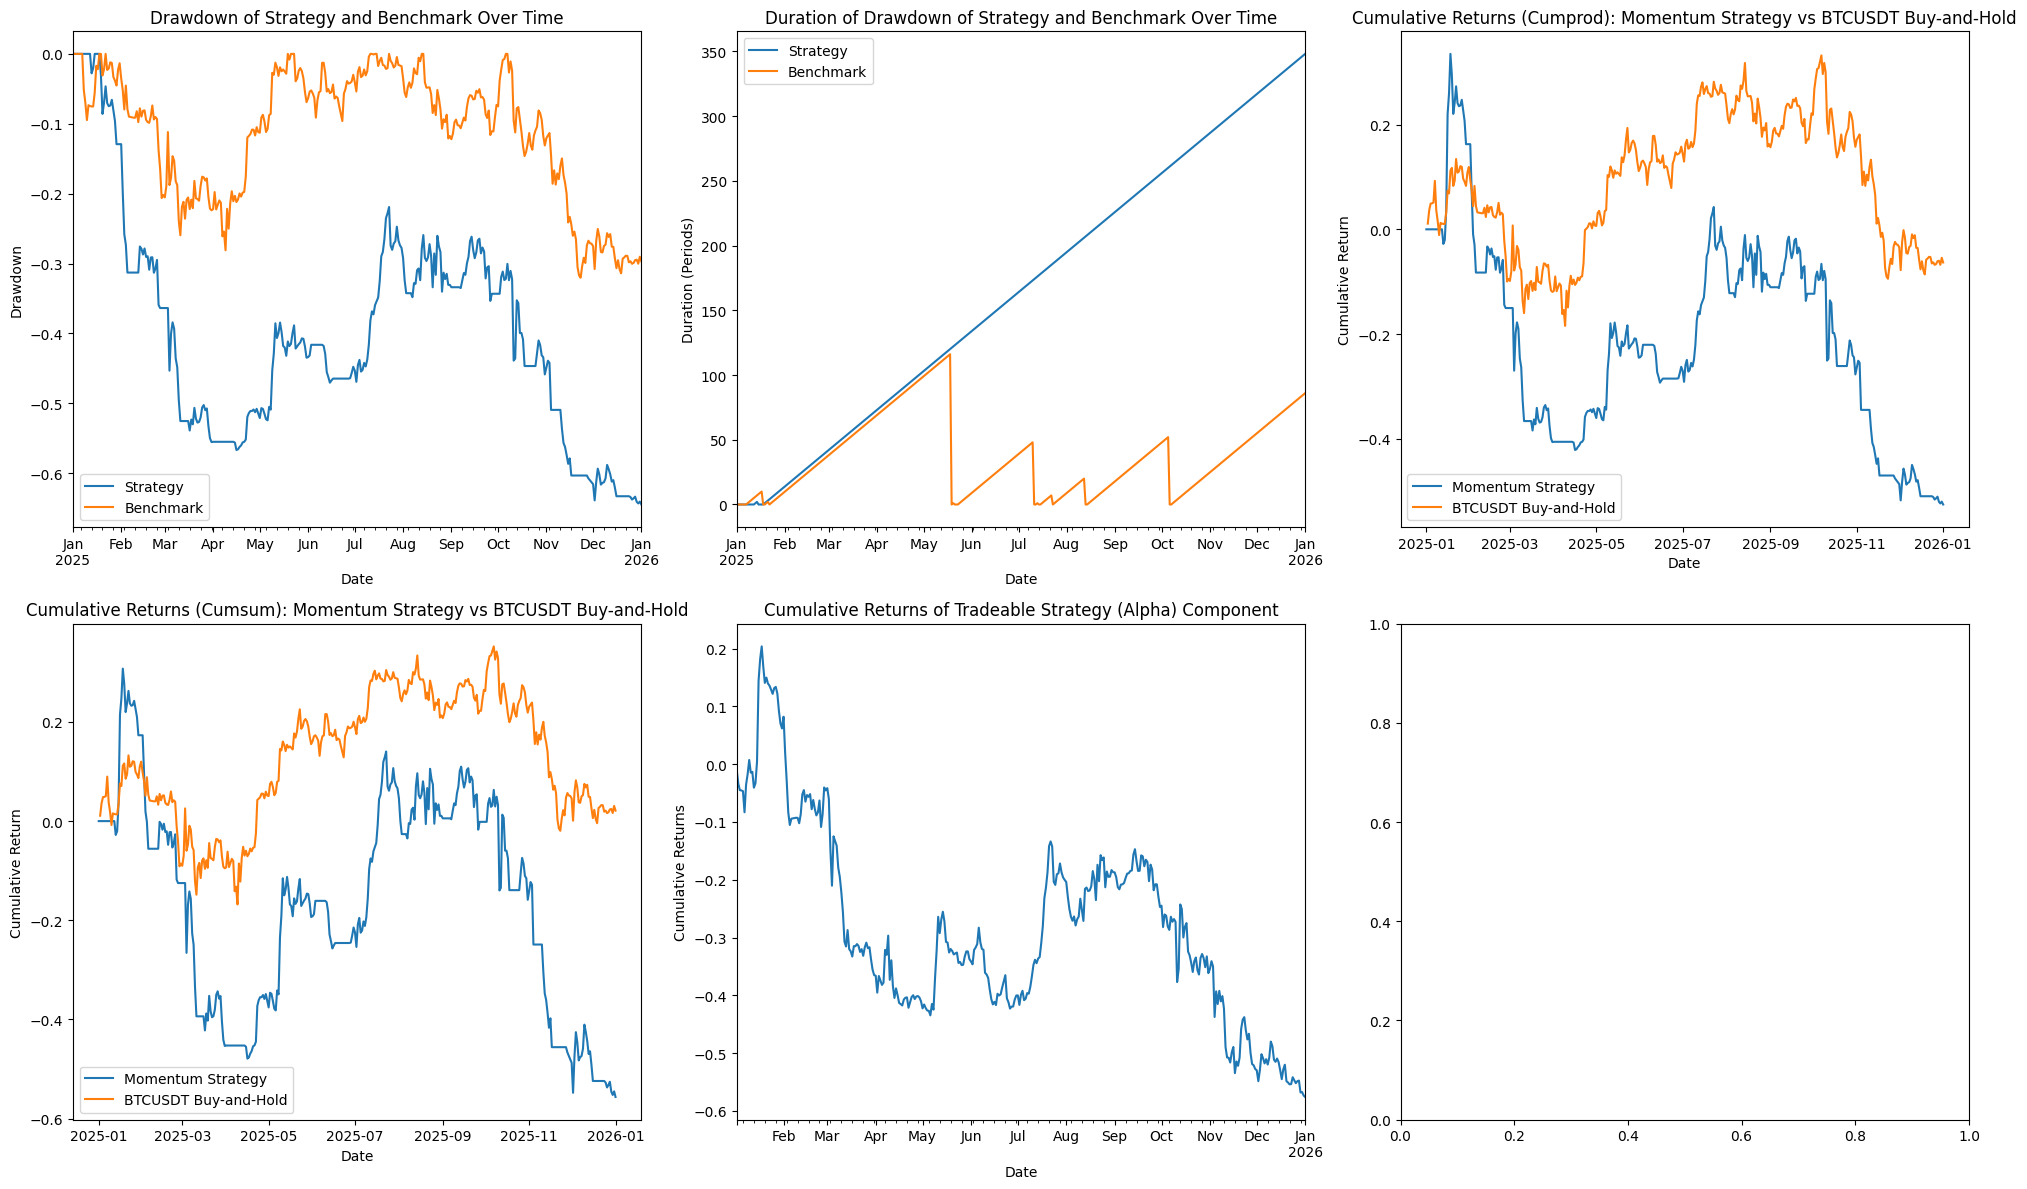

In [16]:
combined_plots(test_strategy_returns, test_benchmark_returns)

In [17]:
# Alpha and Beta of our Long-Only Strategy
benchmark = trading_pairs_df[['BTCUSDT']].pct_change()
benchmark.rename(columns={'BTCUSDT':'Daily Return'}, inplace=True)
derive_alpha_beta(test_strategy_returns, benchmark)

                            OLS Regression Results                            
Dep. Variable:        Strategy Return   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     240.4
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           5.56e-42
Time:                        11:08:46   Log-Likelihood:                 833.11
No. Observations:                 366   AIC:                            -1662.
Df Residuals:                     364   BIC:                            -1654.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0016      0.001     -1.225   

**Remarks:**

From the charts above, we can see that our strategy underperformed the benchmark and gave negative returns over the out-of-sample period. Let us seek to improve the strategy with a few enhancements to the LONG only strategy.

#### 7. Strategy Improvement

**a. Include a SHORT component in our strategy**

Given how we are only exercising LONG positions in our strategy, let us include the option to SHORT pairs when ST MA crosses below LT MA

In [19]:
def compute_ma_crossover_long_short_strategy(dataframe, short_window, long_window):
  df = dataframe.copy()
  # Compute the short and long moving averages for each trading pair in our dataset
  for symbol in df.columns:
    df[f'{symbol}_SMA_{short_window}'] = simple_moving_average(df[symbol], short_window)
    df[f'{symbol}_SMA_{long_window}'] = simple_moving_average(df[symbol], long_window)
    
  # Compute the LONG signal
  for symbol in df.columns:
    if '_SMA_' in symbol:
      continue
    short_sma = df[f'{symbol}_SMA_{short_window}']
    long_sma = df[f'{symbol}_SMA_{long_window}']
    df[f'{symbol}_LONG_signal'] = np.where(short_sma > long_sma, 1.0, 0.0)
    df[f'{symbol}_SHORT_signal'] = np.where(short_sma < long_sma, -1.0, 0.0)
  
  # Equal weight allocation across all trading pairs that have a LONG or SHORT signal
  signal_df = df.filter(regex='(_LONG_signal|_SHORT_signal)')
  
  # Calculate number of long and short signals
  num_signals = signal_df.abs().sum(axis=1)
  weights = signal_df.div(num_signals, axis=0).fillna(0.0)

  # remove the long_signal and short_signal wording on the weights dataframe to make them the same as the trading pairs
  weights.columns = [col.replace('_LONG_signal', '').replace('_SHORT_signal', '') for col in weights.columns]

  # Compute the daily returns for each trading pair
  returns_df = dataframe
  daily_returns = returns_df.pct_change().fillna(0)
  
  # Avoid look-ahead bias by shifting the weights by 1 day
  weights = weights.shift(1).fillna(0.0)

  # Compute the portfolio returns on each day
  portfolio_returns = (weights * daily_returns).sum(axis=1)
  return pd.DataFrame(portfolio_returns, columns=["Strategy Return"])

def backtest_strategy(dataframe, short_window, long_window):
  short_window_list = []
  long_window_list = []
  sharpe_ratio = []
  for sw in short_window:
    for lw in long_window:
      if sw >= lw:
        continue
      
      portfolio_returns = compute_ma_crossover_long_short_strategy(dataframe, sw, lw)
      portfolio_returns = portfolio_returns["Strategy Return"]
      # Compute the Sharpe Ratio (assuming risk-free rate is 0)
      sr = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
      sharpe_ratio.append(sr)
      short_window_list.append(sw)
      long_window_list.append(lw)
  
  results_df = pd.DataFrame({
    'Short_Window': short_window_list,
    'Long_Window': long_window_list,
    'Sharpe_Ratio': sharpe_ratio
  })
  return results_df

Backtesting our improved strategy on the training data

Top 3 Optimal Parameters (Short Window, Long Window):
Short Window: 31.0, Long Window: 32.0, Sharpe Ratio: 1.3165
Short Window: 31.0, Long Window: 33.0, Sharpe Ratio: 1.2346
Short Window: 31.0, Long Window: 34.0, Sharpe Ratio: 1.2300


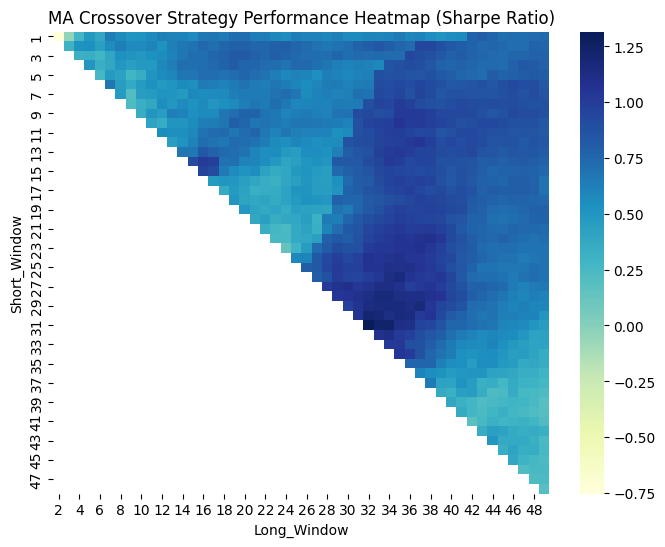

In [20]:
short_window_range = np.arange(1, 50, 1)  # Adjust the steps as needed
long_window_range = np.arange(1, 50, 1)  # Adjust the steps as needed

training_results = backtest_strategy(train_data, short_window_range, long_window_range)
performance_heatmap(training_results)

In [21]:
short_window_optimal = 31
long_window_optimal = 32
test_strategy_long_short_returns = compute_ma_crossover_long_short_strategy(test_data, short_window=short_window_optimal, long_window=long_window_optimal)

# Compare our strategy against the benchmark
test_strategy_long_short_returns_metrics = strategy_performance_metrics(test_strategy_long_short_returns)
benchmark_metrics = benchmark_performance_metrics(test_data)
performance_comparison = compare_strat_and_benchmark(test_strategy_long_short_returns_metrics, benchmark_metrics)
performance_comparison

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_3932/2008990353.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_3932/2008990353.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage


,Strategy,Benchmark
Annualised Return,0.360902,0.014711
Annualised Volatility,0.433643,0.346389
Sharpe Ratio,0.711037,0.042162
Hit Rate,0.491803,0.500000
Max Drawdown (%),25.120015,32.022515
Max Drawdown Duration (Periods),136.000000,116.000000


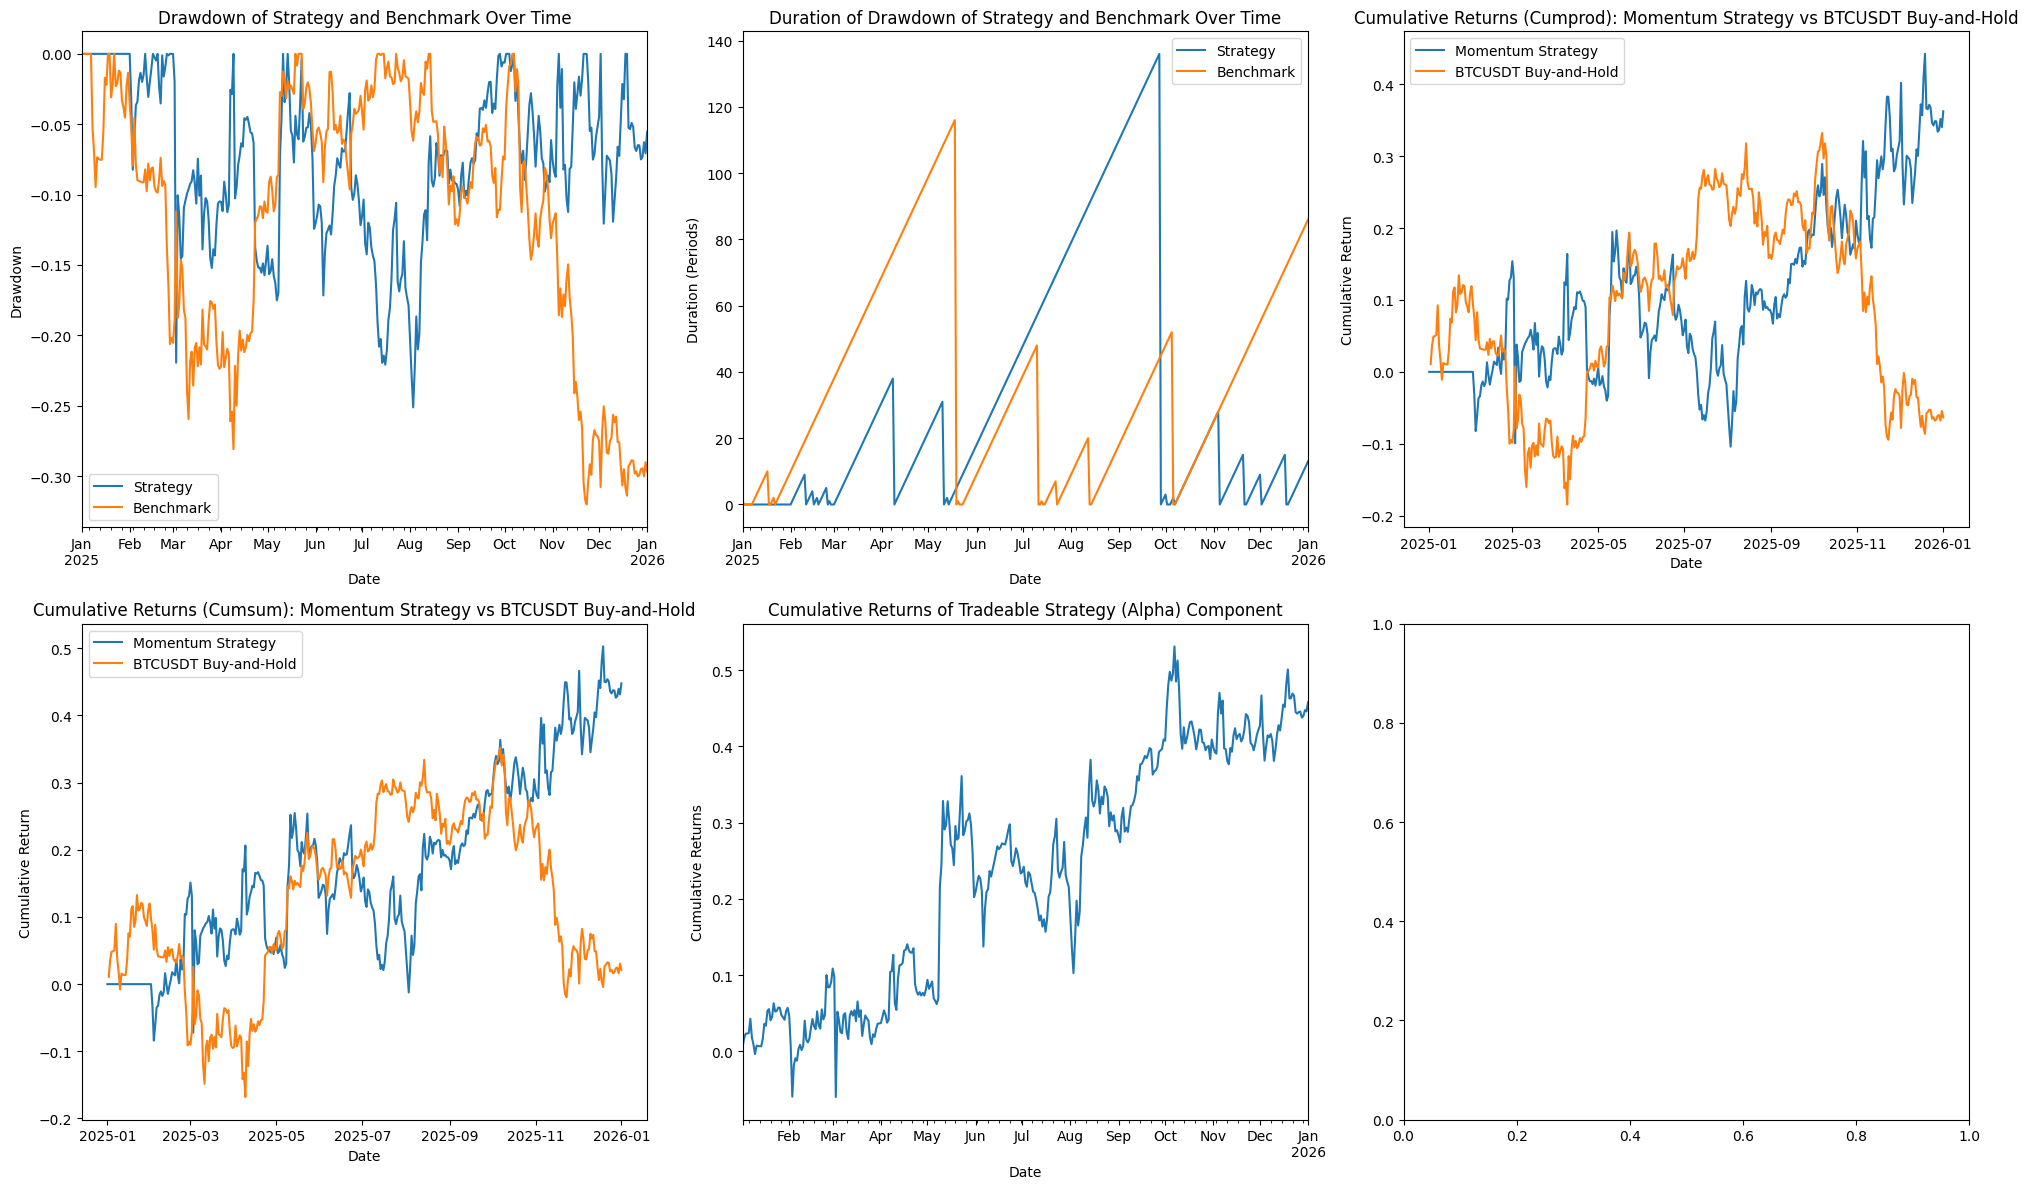

In [22]:
combined_plots(test_strategy_long_short_returns, test_benchmark_returns)

In [23]:
# Alpha and Beta of our Long-Short Strategy
benchmark = trading_pairs_df[['BTCUSDT']].pct_change()
benchmark.rename(columns={'BTCUSDT':'Daily Return'}, inplace=True)
derive_alpha_beta(test_strategy_long_short_returns, benchmark)

                            OLS Regression Results                            
Dep. Variable:        Strategy Return   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     61.12
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           5.85e-14
Time:                        11:09:36   Log-Likelihood:                 827.26
No. Observations:                 366   AIC:                            -1651.
Df Residuals:                     364   BIC:                            -1643.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0013      0.001      0.954   

**Remarks:**

With the inclusion of a SHORT component we can see that our strategy has improved substantially as compared to a LONG-only portfolio, as we are also generating returns when the assets are declining in price. 

One interesting observation here is that our portfolio Beta is negative (i.e -0.4752) which signals an inverse movement to the broader index. This numeric figure translates to the fact that for every 1% increase in the benchmark, our portfolio will decrease by 0.475% and vice versa. Henceforth, we see that our strategy outperformed the benchmark in our out-of-sample data simply because the broader index was on a general decline, and the SHORT component of our strategy enabled us to capitalised on the price decline to generate returns.

From the above metrics, we can see that our strategy still has a higher annualised volatility compared to the benchmark. Let us improve the strategy via the construction of an equal volatility weighted portfolio.

**b. Equal Volatility Weights (`eqvol_weights`)**
  - Each asset is scaled inversely to its **volatility**, creating a **risk-parity-like allocation**.
  - Formula:  
    $$
    w_i \propto \frac{1}{\sqrt{\sigma_{ii}}}
    $$
  - This method **balances risk contribution** rather than dollar exposure, giving **lower-volatility assets more weight**. More formally, we can define the normalised form of the inverse volatility weights formula as follow:
    $$
    w_i = \frac{\frac{1}{\sqrt{\sigma_{ii}}}}{\sum{\frac{1}{\sqrt{\sigma_{ii}}}}}
    $$

Based on the formula above, we can define our function for equal volatility weighting as follow in our first method. As for the signa, which is our covariance matrix, we will be computing it from the 30-day rolling window of the top X stocks that we have chosen.

In [24]:
def eqvol_weights(sigma):
  wgt = 1/np.sqrt(np.diag(sigma))
  wgt = wgt / np.abs(wgt).sum()
  return wgt

def eqvol_weights_computation(dataframe):
  """
  1. Compute the covariance matrix from the dataframe of the X assets that we have chosen
  2. Use the eqvol_weights function to compute the equal volatility weights
  3. Return the weights as a pandas Series
  """
  # Step 1: Define our correlation matrix and convert it to a numpy array
  corr = dataframe.corr().values
  corr = np.array(corr)
    
  # Step 2: Compute our volatilities and convert it to a covariance matrix: sigma = D @ corr @ D
  vols = np.diag(dataframe.std().values) / np.sqrt(252) # daily vols of our X assets  
  sigma = vols @ corr @ vols # covariance matrix
    
  # Compute the equal volatility weights using the eqvol_weights function
  weights = eqvol_weights(sigma)
  # Return the weights as a pandas Series with the index as the asset names
  return pd.Series(weights, index=dataframe.columns)

With that, we can update our rolling window strategy function to incorporate the equal volatility weighting method

In [25]:
# Optimised
def ma_crossover_long_short_eq_vol_strategy(dataframe, short_window, long_window):
  df = dataframe.copy()
  symbols = df.columns.tolist()

  # ===== 1. Compute SMAs (vectorised) =====
  sma_short = df.rolling(short_window).mean()
  sma_long = df.rolling(long_window).mean()

  # ===== 2. Generate signals (vectorised) =====
  long_signal = (sma_short > sma_long).astype(float)
  short_signal = -(sma_short < sma_long).astype(float)

  # ===== 3. Initialise weights =====
  weights_df = pd.DataFrame(0.0, index=df.index, columns=symbols)

  # ===== 4. Rolling equal-vol weighting (date loop unavoidable) =====
  for i in range(252, len(df)):
    date = df.index[i]

    long_assets = long_signal.iloc[i]
    short_assets = short_signal.iloc[i]

    active_assets = long_assets[long_assets == 1].index.tolist() + short_assets[short_assets == -1].index.tolist()

    if not active_assets:
      continue

    price_window = df[active_assets].iloc[i-252:i]
    eq_vol_w = eqvol_weights_computation(price_window)

    # Assign signed weights
    for asset in active_assets:
      if long_assets[asset] == 1:
        weights_df.at[date, asset] = eq_vol_w[asset]
      else:
        weights_df.at[date, asset] = -eq_vol_w[asset]

  # ===== 5. Shift weights to avoid look-ahead =====
  weights = weights_df.shift(1).fillna(0.0)

  # ===== 6. Compute strategy returns =====
  pct_returns = df.pct_change().fillna(0.0)
  strat_returns = (weights * pct_returns).sum(axis=1)

  return strat_returns.to_frame("Strategy Return")

def backtest_strategy(dataframe, short_window, long_window):
  short_window_list = []
  long_window_list = []
  sharpe_ratio = []
  for sw in short_window:
    for lw in long_window:
      if sw >= lw:
        continue
      
      portfolio_returns = ma_crossover_long_short_eq_vol_strategy(dataframe, sw, lw)
      portfolio_returns = portfolio_returns["Strategy Return"]
      # Compute the Sharpe Ratio (assuming risk-free rate is 0)
      sr = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
      sharpe_ratio.append(sr)
      short_window_list.append(sw)
      long_window_list.append(lw)
  
  results_df = pd.DataFrame({
    'Short_Window': short_window_list,
    'Long_Window': long_window_list,
    'Sharpe_Ratio': sharpe_ratio
  })
  return results_df

Backtest our improved strategy on our training data

Top 3 Optimal Parameters (Short Window, Long Window):
Short Window: 28.0, Long Window: 36.0, Sharpe Ratio: 0.9448
Short Window: 31.0, Long Window: 37.0, Sharpe Ratio: 0.9399
Short Window: 28.0, Long Window: 38.0, Sharpe Ratio: 0.9316


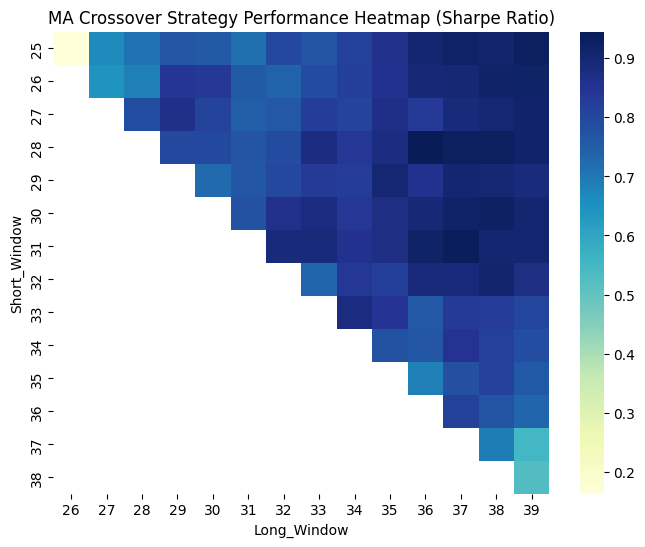

In [26]:
# Decreased the range for faster computation
short_window_range = np.arange(25, 40, 1)  # Adjust the steps as needed
long_window_range = np.arange(25, 40, 1)  # Adjust the steps as needed

training_results = backtest_strategy(train_data, short_window_range, long_window_range)
performance_heatmap(training_results)

Let us recompute the performance of our updated strategy using the 2nd most optimal pairs from the chart above

In [39]:
short_window_optimal = 31
long_window_optimal = 37
test_strategy_long_short_eq_vol_returns = ma_crossover_long_short_eq_vol_strategy(test_data, short_window=short_window_optimal, long_window=long_window_optimal)

# Compare our strategy against the benchmark
test_strategy_long_short_eq_vol_returns_metrics = strategy_performance_metrics(test_strategy_long_short_eq_vol_returns)
benchmark_metrics = benchmark_performance_metrics(test_data)
performance_comparison = compare_strat_and_benchmark(test_strategy_long_short_eq_vol_returns_metrics, benchmark_metrics)
performance_comparison

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_3932/2008990353.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_3932/2008990353.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage


,Strategy,Benchmark
Annualised Return,0.385679,0.014711
Annualised Volatility,0.347875,0.346389
Sharpe Ratio,0.938273,0.042162
Hit Rate,0.185792,0.500000
Max Drawdown (%),28.909824,32.022515
Max Drawdown Duration (Periods),41.000000,116.000000


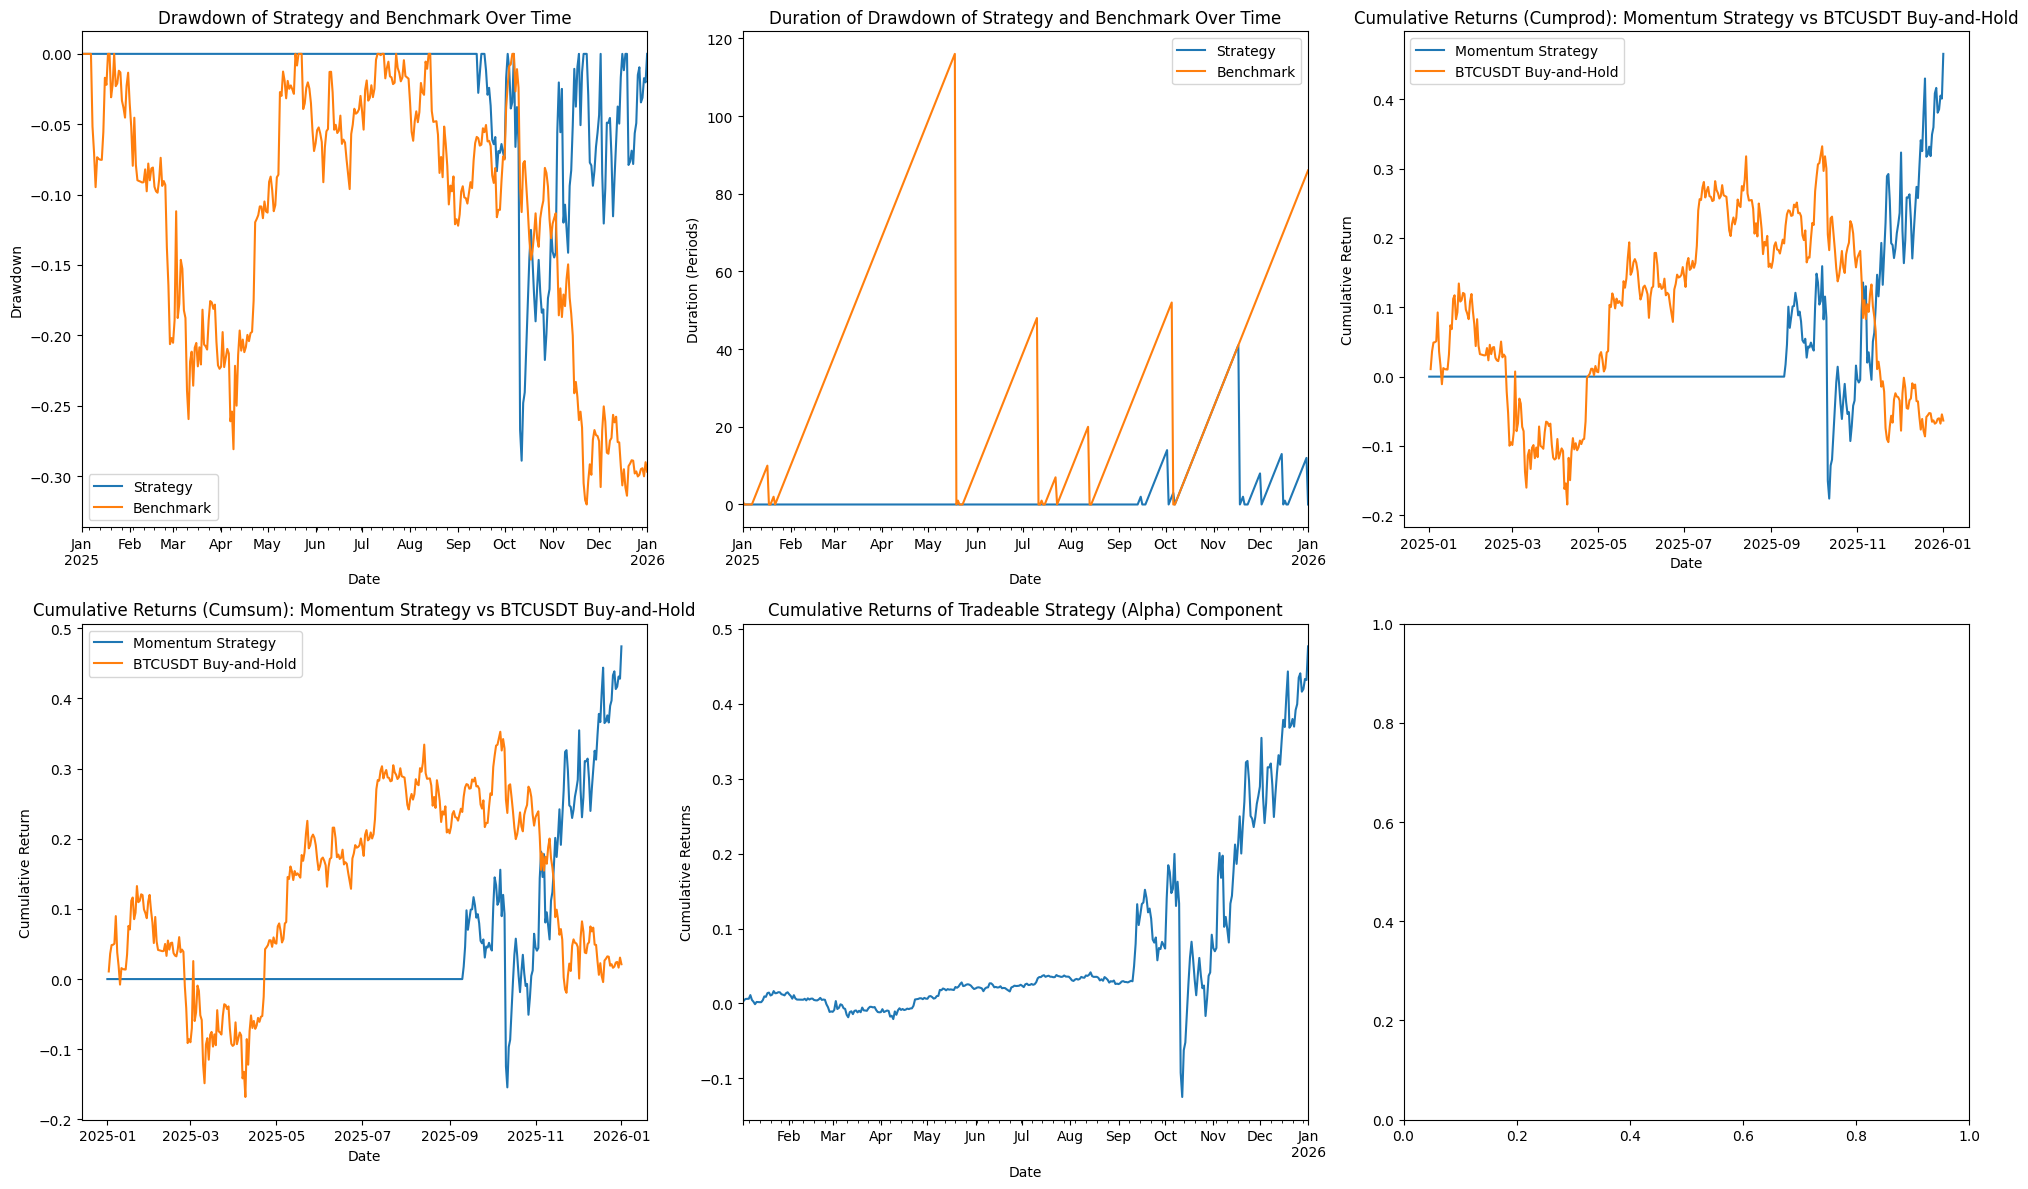

In [40]:
combined_plots(test_strategy_long_short_eq_vol_returns, test_benchmark_returns)

In [41]:
# Alpha and Beta of our Long-Short Equal Volatility Strategy
benchmark = trading_pairs_df[['BTCUSDT']].pct_change()
benchmark.rename(columns={'BTCUSDT':'Daily Return'}, inplace=True)
derive_alpha_beta(test_strategy_long_short_eq_vol_returns, benchmark)

                            OLS Regression Results                            
Dep. Variable:        Strategy Return   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.650
Date:                Mon, 12 Jan 2026   Prob (F-statistic):             0.0180
Time:                        11:25:47   Log-Likelihood:                 882.34
No. Observations:                 366   AIC:                            -1761.
Df Residuals:                     364   BIC:                            -1753.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0013      0.001      1.147   

After adjusting for equal volatility weighting of our portfolio, we can see that our Sharpe Ratio has increased to 0.938, which once again outperformed the benchmark. In addition, our annualised volatility has decreased from the first iteration, and the annualised return has also increased with this new approach. Max drawdown has also decreased as a result.

Our beta has also improved to a value of -0.1243, which in comparison to the previous iteration, was -0.4752.

#### 8. Modelling Transaction Cost and other Factors

**Step 1: Computing turnover**

Turnover measures how frequently the portfolio positions change. To do so, we will perform the following actions
  1. Any missing weights (NaN) are replaced with 0. This ensures that when assets are added or removed from the universe, their contribution to turnover is treated cleanly — as if there were no position
  2. port.shift() moves the entire DataFrame one row down in time, so each row can be compared to the previous portfolio. This represents the portfolio weights at the previous timestamp.
  3. We compute the difference between the portfolio weights at the present and previous timestamps. This measures the change in portfolio weights for each asset between two consecutive time steps. If a weight stays the same, the difference is 0. If it changes, the difference reflects the amount of reallocation (buying/selling).
  4. Taking the absolute value converts all changes into positive numbers — since turnover measures how much the portfolio changes, not the direction.
  4. Summing across all columns (assets) at each timestamp gives the total portfolio turnover per period. For example, if the portfolio sold 0.3 of BTC and bought 0.3 of ETH, the turnover would be 0.3 + 0.3 = 0.6.


**Step 2: Compute the Gross of Transaction Costs**
  
This calculation ignores trading frictions such as slippage, bid-ask spreads, and commissions. The term “gross” indicates that this is the raw performance — before subtracting any turnover-related costs. as well as the portfolio Sharpe Ratio. To do so, we will perform the series of steps below:

1. **port.shift()**: The portfolio weights are shifted one period backward in time. This ensures we are using the weights decided at time t-1 to measure returns realized at time t. This avoids lookahead bias as you cannot trade on information you do not yet have.
2. **(port.shift() * ret)**: Here we multiply the previous period’s weights by the current period’s asset returns. This gives the contribution of each asset to the portfolio’s total return at time t.
3. **.sum(1)**: Summing across assets (axis = 1) adds up all contributions to get the portfolio’s overall return at each timestamp.

**Step 3: Net of Realise Returns**

This final step adjusts the portfolio’s gross returns to account for transaction costs, yielding the net realized returns.

**1. `tcost_bps = 20`**

Transaction cost per unit of turnover is assumed to be **20 basis points (bps)**.
- 1 basis point (bp) = 0.01%, so  
- **20 bps = 0.20% = 0.0020** in decimal form.

As defined above, we will be using 0.2% for our market order fee. This includes both **commissions** (e.g., exchange fees) and **slippage** (price impact when trading).

**2. `to * tcost_bps * 1e-4`**

Recall that:
- `to` is **turnover**, the total fraction of the portfolio traded between time steps.
- `tcost_bps * 1e-4` converts basis points to a **decimal cost per unit turnover**.

So, for each timestamp:
$$
\text{Transaction Cost}_t = \text{Turnover}_t \times \text{Cost per Unit Turnover}
$$

**Example:**
If turnover = 0.6 (i.e., 60% of the portfolio was traded), and cost = 20 bps = 0.0020, then:
$$
\text{Transaction Cost}_t = 0.6 \times 0.0020 = 0.0012 = 0.12\%
$$

**3. `gross_ret.subtract(..., fill_value=0)`**

Subtracts transaction costs from gross returns to compute **net returns**:
$$
\text{Net Return}_t = \text{Gross Return}_t - \text{Transaction Cost}_t
$$

The `fill_value=0` ensures missing values (NaNs) are treated as **0** during subtraction. This can be expressed in mathematical form as follow:
$$
\text{Net Return}_t = \sum_i w_{t-1,i} r_{t,i} - \text{Turnover}_t \times \text{Cost per Unit Turnover}
$$

Where:
- `gross_ret` → what your portfolio would earn in a **frictionless world**.  
- `to * tcost_bps * 1e-4` → represents the **drag from trading activity**.  
- `net_ret` → what you **actually keep** after paying for trading.

For this section, we will be sticking to the ```eqvol_weights``` and ```LONG-SHORT``` improvements made to our strategy

In [42]:
def ma_crossover_long_short_eq_vol_strategy_and_turnover(dataframe, short_window, long_window):
  df = dataframe.copy()
  symbols = df.columns.tolist()

  # ===== 1. Compute SMAs (vectorised) =====
  sma_short = df.rolling(short_window).mean()
  sma_long = df.rolling(long_window).mean()

  # ===== 2. Generate signals (vectorised) =====
  long_signal = (sma_short > sma_long).astype(float)
  short_signal = -(sma_short < sma_long).astype(float)

  # ===== 3. Initialise weights =====
  weights_df = pd.DataFrame(0.0, index=df.index, columns=symbols)

  # ===== 4. Rolling equal-vol weighting (date loop unavoidable) =====
  for i in range(252, len(df)):
    date = df.index[i]

    long_assets = long_signal.iloc[i]
    short_assets = short_signal.iloc[i]

    active_assets = long_assets[long_assets == 1].index.tolist() + short_assets[short_assets == -1].index.tolist()

    if not active_assets:
      continue

    price_window = df[active_assets].iloc[i-252:i]
    eq_vol_w = eqvol_weights_computation(price_window)

    # Assign signed weights
    for asset in active_assets:
      if long_assets[asset] == 1:
        weights_df.at[date, asset] = eq_vol_w[asset]
      else:
        weights_df.at[date, asset] = -eq_vol_w[asset]

  # ===== 5. Shift weights to avoid look-ahead =====
  weights = weights_df.shift(1).fillna(0.0)

  # ===== 6. Compute strategy returns =====
  pct_returns = df.pct_change().fillna(0.0)
  strat_returns = (weights * pct_returns).sum(axis=1)

  return strat_returns.to_frame("Strategy Return"), weights


# Define the function to compute turnover
def compute_turnover(weights_dataframe, returns_dataframe):
  wdf = weights_dataframe.copy()
  to = (wdf.fillna(0) - wdf.shift().fillna(0)).abs().sum(1)

  # Plot the turnover over time
  plt.figure(figsize=(15,6))
  plt.plot(to.index, to, label='Turnover')
  plt.xlabel('Date')
  plt.ylabel('Turnover')
  plt.title('Portfolio Turnover Over Time')
  plt.legend()
  plt.show()
  
  print(f"Average Turnover: {to.mean()}")
  
  # Gross of transaction costs returns
  gross_ret = returns_dataframe
  print("Gross of transaction cost returns", (gross_ret.mean() / gross_ret.std() * np.sqrt(252))[0])
  
  # Net of transaction costs returns
  """
  Some small adjustments to be made: Since our gross_return (i.e strat return may not have the same dates as the turnover series), we will align them to turnover dates
  This will not be an issue since we are using the rolling window strategy which will have some NaN values at the start before hitting the rolling window period
  1. Reindex the gross_ret to match the index of the turnover series
  2. Fill any NaN values with 0, since on those dates we have no trades and hence no returns
  3. Compute the transaction costs as turnover * market_order_fee
  4. Subtract the transaction costs from the gross returns to get the net returns
  5. Compute the net returns performance metrics
  6. Print the net returns performance metrics
  """
  gross_ret = gross_ret.reindex(to.index).fillna(0)

  tcost_bps = market_order_fee
  trans_cost = pd.DataFrame(data = to*tcost_bps, index=gross_ret.index, columns=['Transaction Cost'])
  returns_tcost_df = pd.concat([gross_ret, trans_cost], axis=1)
  returns_tcost_df['Net Return'] = returns_tcost_df['Strategy Return'] - returns_tcost_df['Transaction Cost']

  net_return = returns_tcost_df['Net Return']
  print("Net Return after transaction costs:", net_return.sum())
  print("Annualised Sharpe Ratio after transaction costs:", net_return.mean() / net_return.std() * np.sqrt(252))

In [47]:
ma_cross_over_long_short_eqvol_assets, ma_cross_over_long_short_eqvol_weights = ma_crossover_long_short_eq_vol_strategy_and_turnover(test_data, short_window=31, long_window=37)

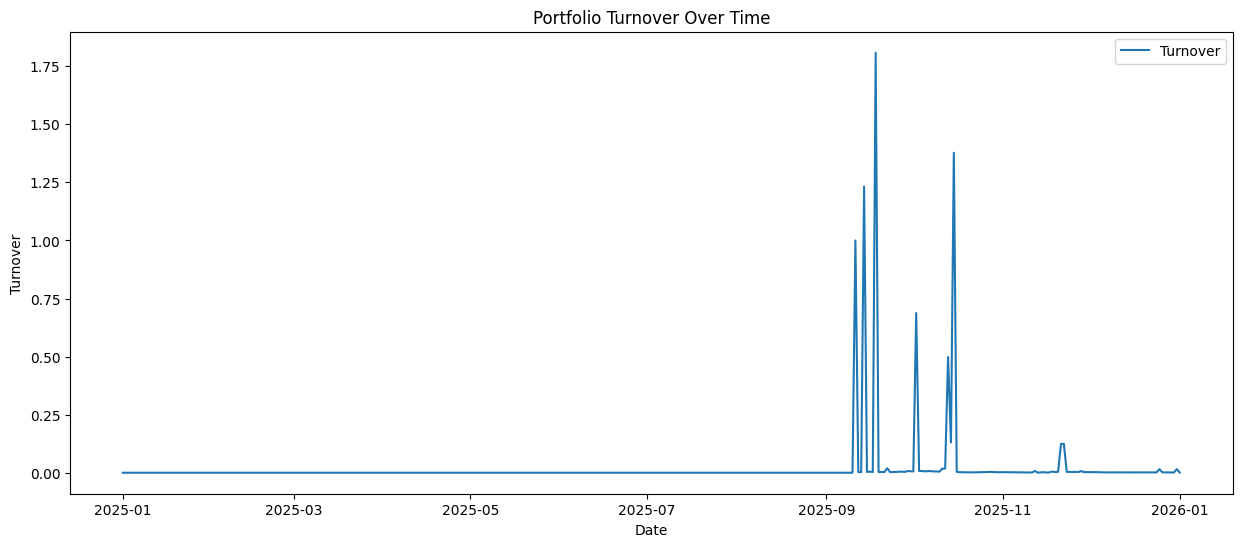

Average Turnover: 0.020040637725365688
Gross of transaction cost returns 0.9382732483275377
Net Return after transaction costs: 0.4593894251809771
Annualised Sharpe Ratio after transaction costs: 0.9106639684323895


/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_3932/3810961396.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Gross of transaction cost returns", (gross_ret.mean() / gross_ret.std() * np.sqrt(252))[0])


In [48]:
compute_turnover(ma_cross_over_long_short_eqvol_weights, ma_cross_over_long_short_eqvol_assets)

**Remarks:**

---

Given that we maintain the LONG and SHORT positions in our asset over time as long as the MA crossover criterias are met, this contributed to a relatively low turnover as compared to our rolling-mean momentum strategy, where the portfolio rebalancing is dependent on our holding period. Henceforth, a downside to our first strategy would be that turnover could be higher if our optimal holding period is shorter. 

While the same could be said for the MA-crossover strategy when the difference between the ST and LT MAs are small, a benefit of this cross-over strategy is that we can implement additional constraints like having a minimum difference between ST and LT MA windows, so as not to expose our portfolio to short term noises and volatile swings.

#### Conclusion

We can see that our Moving-Average Crossover Long-Short Equal Volatility Strategy has significantly outperformed the benchmark across all metrics. Although we had to use the 2nd Sharpe Optimal pairs for our ST and LT MA windows, the most Sharpe optimal pair still yielded a decent performance on our test data. As a follow-up for future improvements, further analysis could be done on why our Sharpe optimal pairs trained on the in-sample data yielded varying performance on our out-of-sample data.